In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt


In [2]:
np.random.seed(1)

# Problem setup:

We're going to have a small number of (X, Y) data points.
We will see how the 

# Make the truth data: all zeros, but there's one noise point at 1

An omniscient model would ignore the 1 noise point and predict all zeros... but it will try to fit through that noise point at y=1.


In [3]:
X_MAX = 2 * np.pi
def make_data(m):
    # Make Xs scattered on interval [0, 2pi]
    X = X_MAX * np.random.rand(m,)
    # Y's are all zero (1e-10 for plotting purposes)
    Y = 1e-9 + np.zeros((m,))
    # ...except for one noise point
    Y[m//2] = 1
    return X, Y


## Form the A matrix for fitting, along with `fit()` and `predict()` functions

In [4]:
def form_A(X, order):
    # N is the highest order sin/cos, so num terms is n = 2order + 1
    # X has m data points
    m = X.shape[0]
    A = np.zeros((m, 2*order + 1))
    A[:, 0] = 1
    for k in range(1, order+1):
        A[:, k] = np.cos(X * k)
        A[:, k+order] = np.sin(X * k)
    return A

def predict(coeffs, xs):
    """Take in the coefficients of the sin/cosine terms, and the x locations,
    and output the model predicted ys"""
    order = (len(coeffs) - 1) // 2
    m = len(xs)
    idxs = np.arange(1, order+1).reshape((1, order))
    a0 = coeffs[0]
    cos_terms = np.sum(coeffs[1:(order+1)] * np.cos(xs.reshape((-1, 1)) * idxs), axis=1)
    sin_terms = np.sum(coeffs[order+1:] * np.sin(xs.reshape((-1, 1)) * idxs), axis=1)
    ys = a0 + cos_terms + sin_terms
    return ys


def calculate_avg_misfit(y_hat, y_truth = 0):
    # The real data should be all 0s (except that one noisy point), so a 0 line would be perfect
    return np.sum(np.abs(y_hat - y_truth)) / len(y_hat)

def fit(X, Y, order, x_test=None, x_max=X_MAX, print_misfit=True):
    """Fit the sin/cos model"""
    A = form_A(X, order)
    
    m = len(X)
    n = 2*order + 1
    assert A.shape == (m, n)
    # If overdetermined system (m > n, more data points (rows) than features (columns)), 
    # this would be a least squares fitting of the model.
    # coeffs = np.linalg.lstsq(A, Y, rcond=None)[0]
    # For fat A (m < n), we'll use the pseudoinverse to fit
    coeffs = np.linalg.pinv(A) @ Y
    if x_test is None:
        x_test = np.linspace(0, X_MAX, 500)
    y_hat = predict(coeffs, x_test)
    
    misfit = calculate_avg_misfit(y_hat)
    if print_misfit:
        print(f"Average misfit: {misfit}")
    return x_test, y_hat, misfit


## Case: m > n, more data points than model parameters

The model does it's best to fit all points, but there are fewer parameters than data points, so we're doing a least-squares regression

Average misfit: 0.28387035039514


<IPython.core.display.Javascript object>


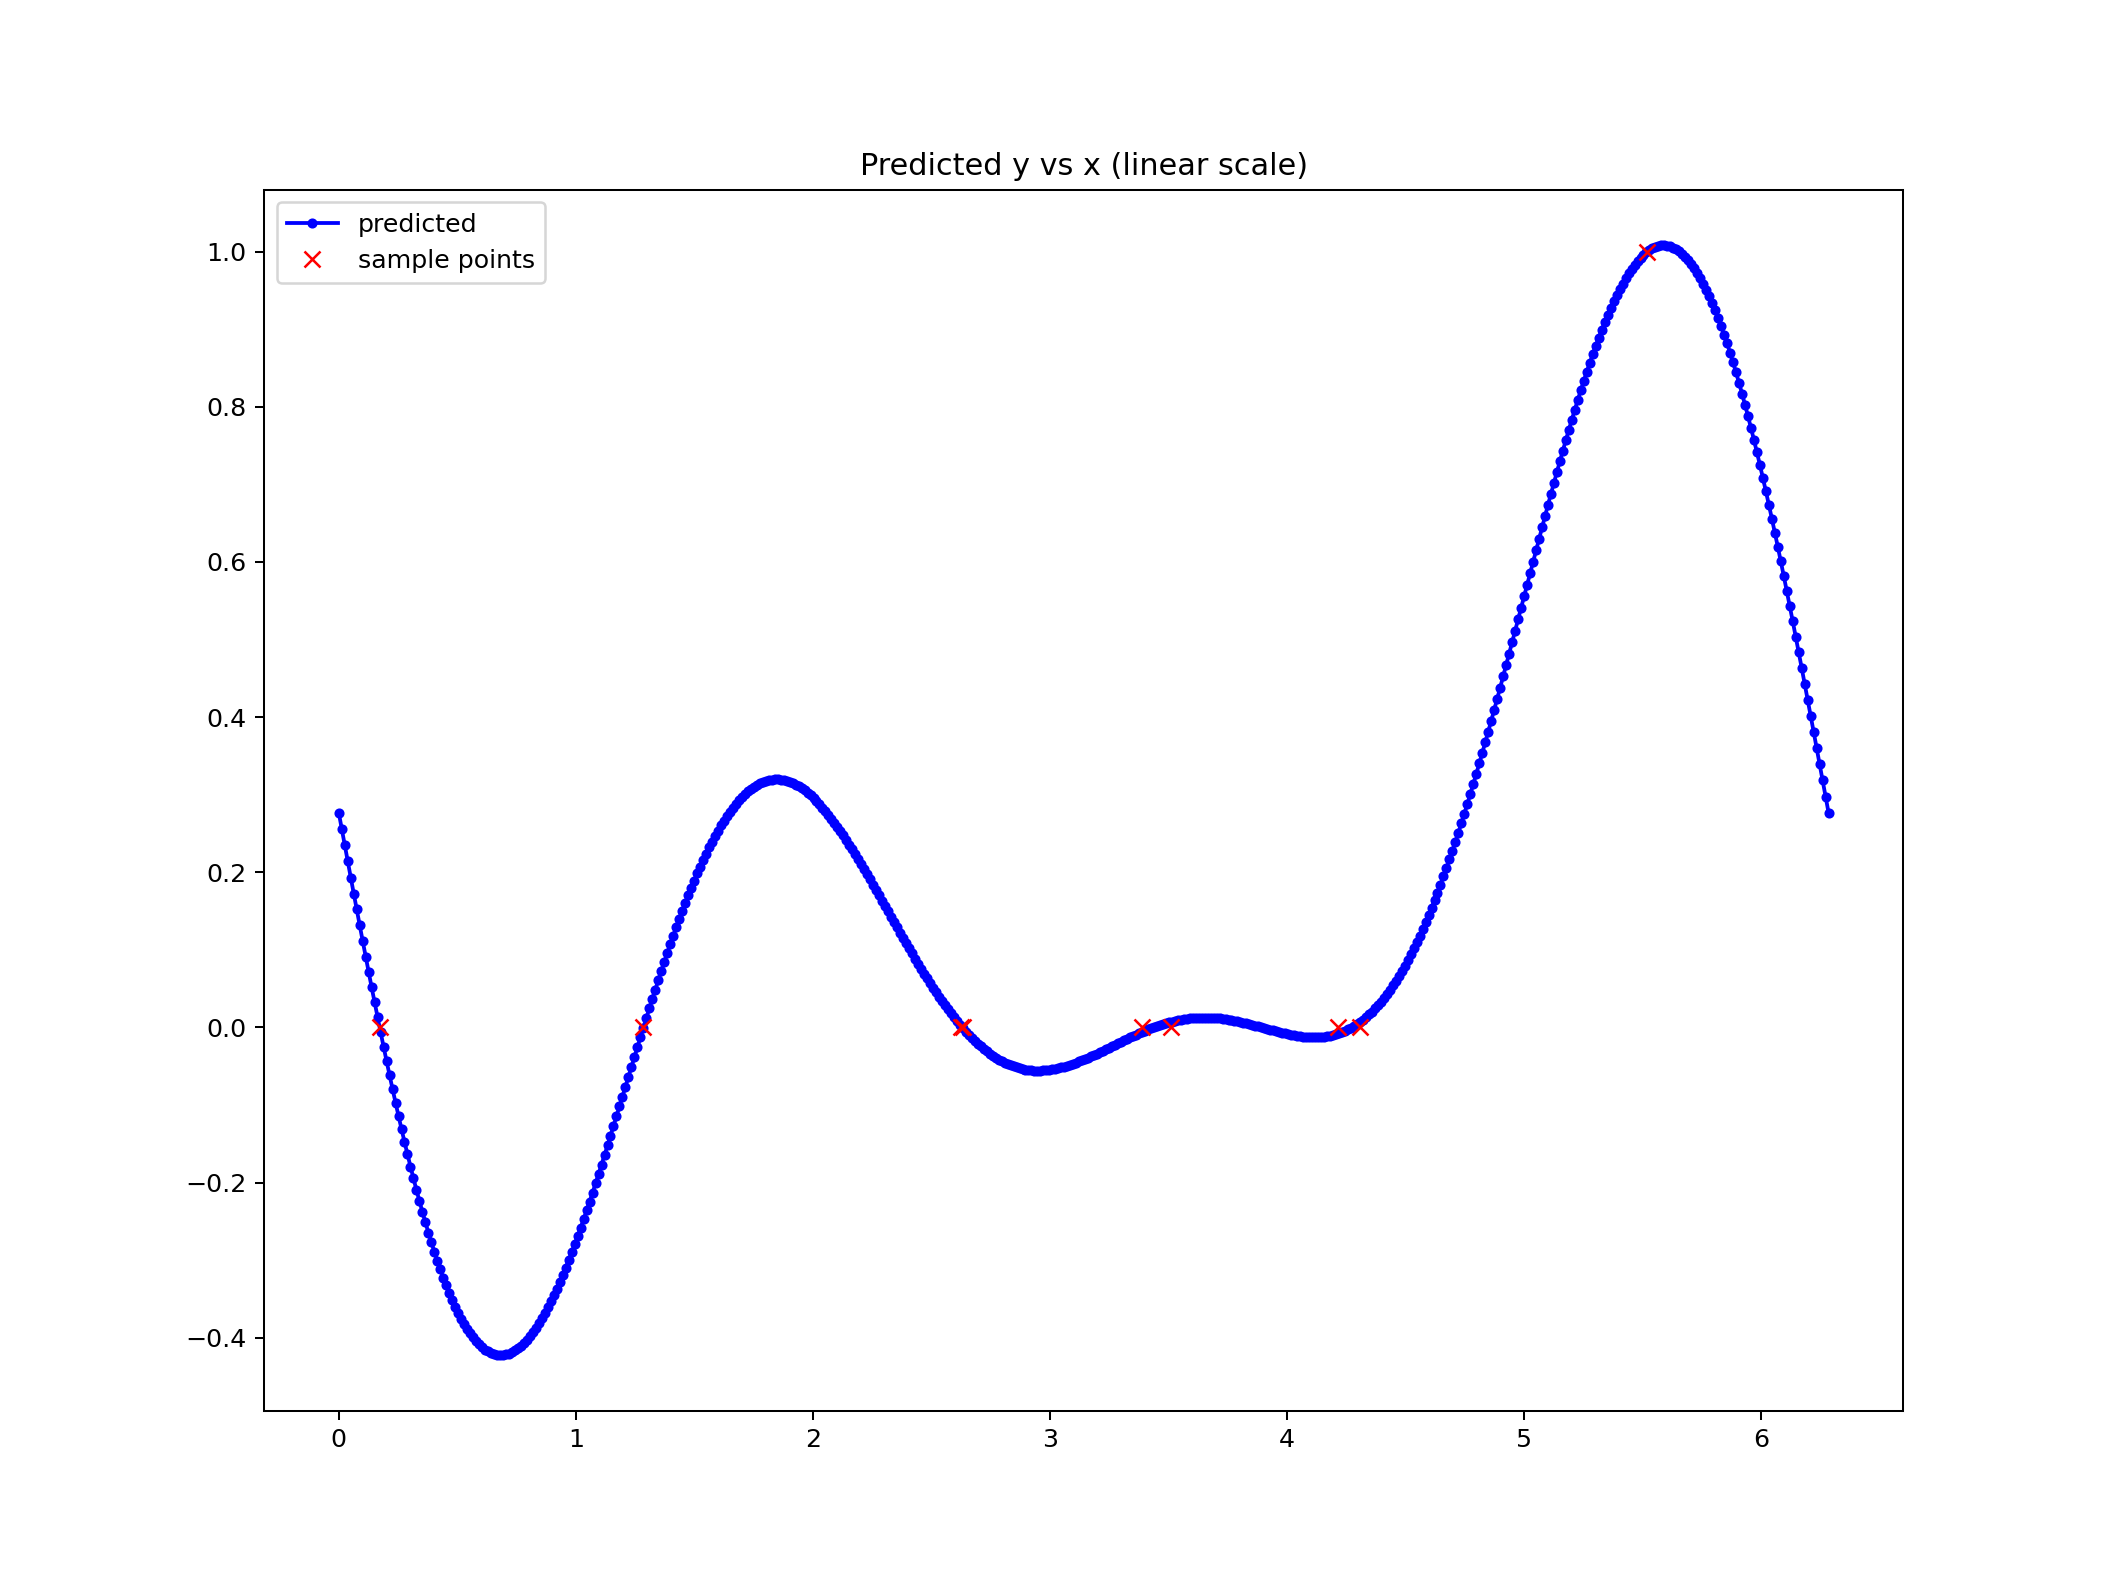

In [9]:
# m = Number of data points
# n = Number of parameters to fit
m = 9
order = 3
# n = 2*order + 1
X, Y = make_data(m)


x_test, y_hat, misfit = fit(X, Y, order)

plt.figure()
plt.plot(x_test, y_hat, 'b.-', label='predicted')
plt.plot(X, Y, 'rx', label='sample points')
plt.title("Predicted y vs x (linear scale)")
plt.legend()

For a more "energy-like" view, we'll plot in a log scale. Any peaks above 0 can be considered "noise energy", as the truth would be all 0s.

<IPython.core.display.Javascript object>


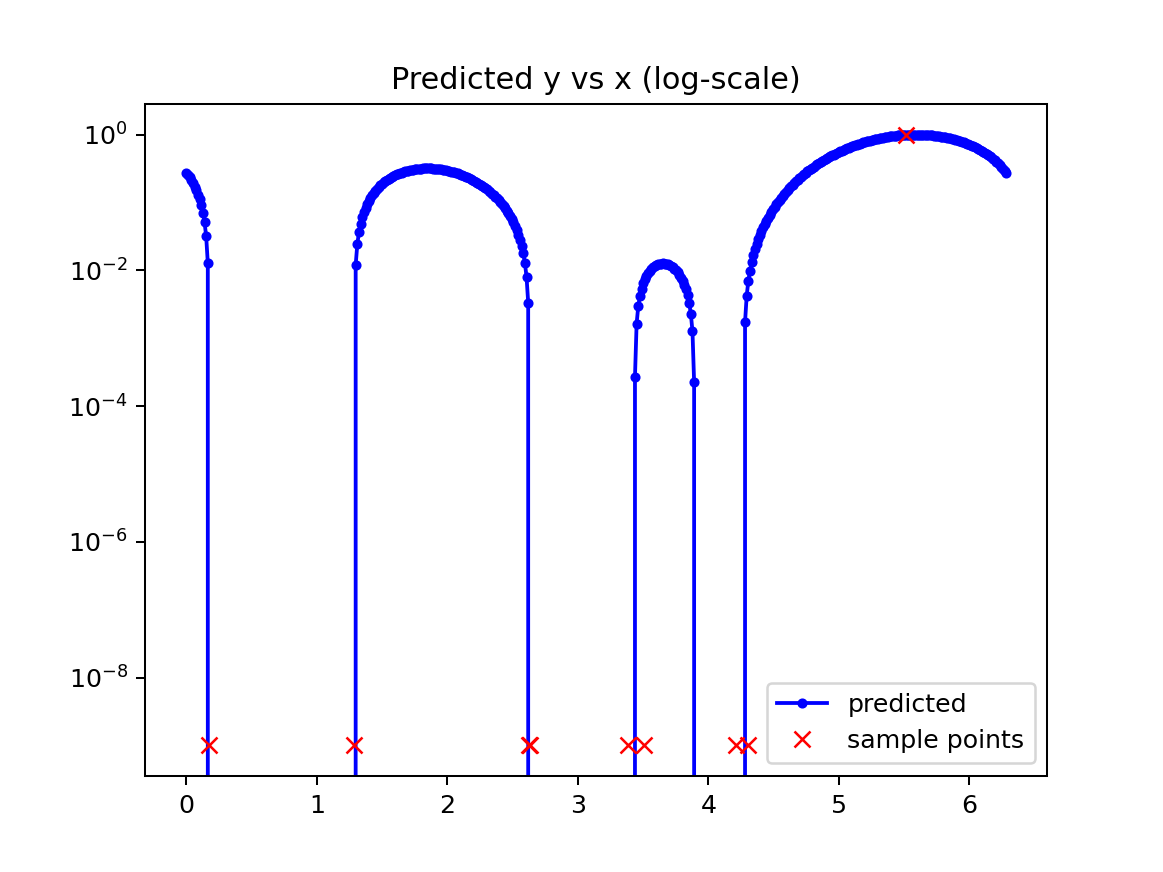

In [10]:
plt.figure()
plt.semilogy(x_test, y_hat, 'b.-', label='predicted')
plt.semilogy(X, Y, 'rx', label='sample points')
plt.title("Predicted y vs x (log-scale)")
plt.legend()

The model has `order` number of large humps, where large, badly-fitting spikes occur (where the humps might wrap around the `2 pi` point, since the sines/cosines are periodic there).

# Overfitting: m == n
The number of sin and cosine terms will now be equal to the number of data points to fit. 

This is normally shown as the **worst-case scenario**, where we can interpolate the data (match the training points exactly), but in between those, the model goes wildly off the rails.

Average misfit: 0.25170843774973783


<IPython.core.display.Javascript object>


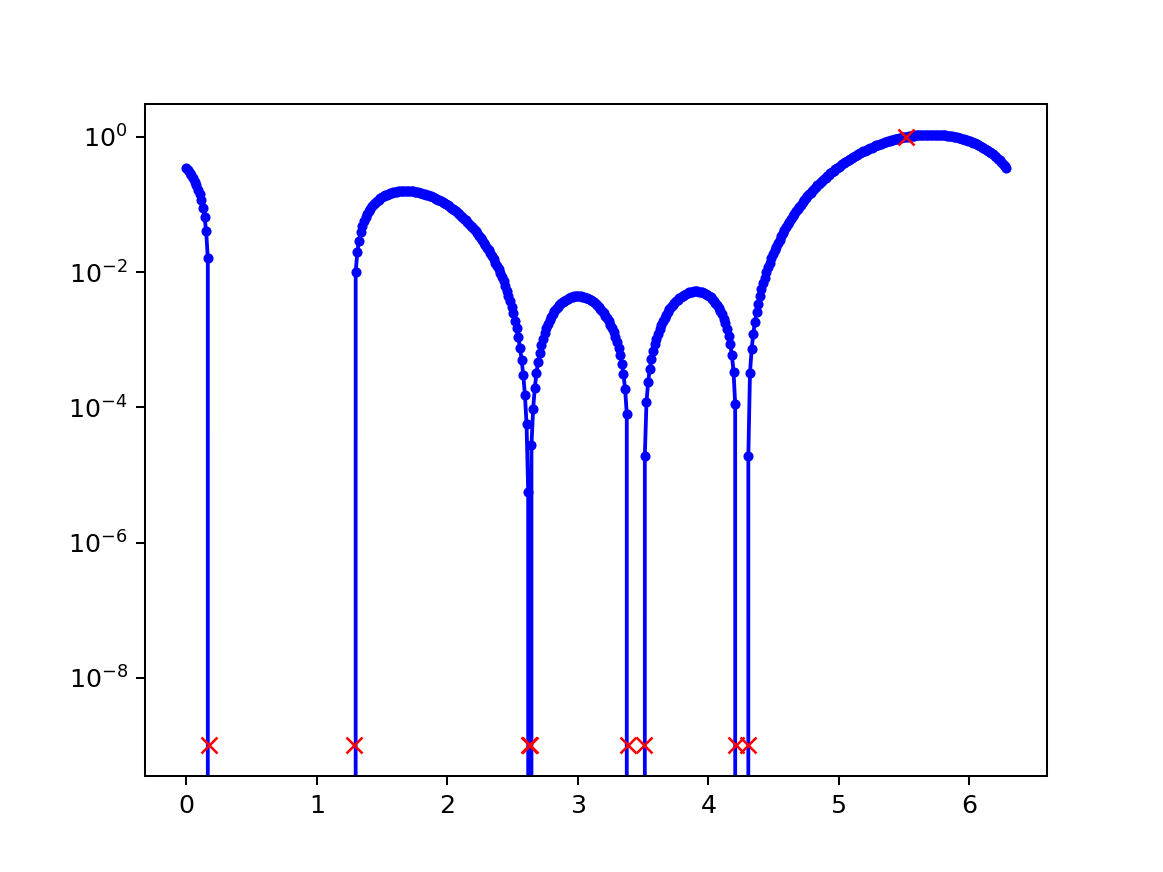

In [11]:
order = m // 2
n = 2*order + 1
assert n == m

x_test, y_hat, misfit = fit(X, Y, order)

plt.figure()
plt.semilogy(x_test, y_hat, 'b.-')
plt.semilogy(X, Y, 'rx')
plt.show()

# Try n > m
Let's use twice as many parameters as data points

Average misfit: 0.11461243896717567


<IPython.core.display.Javascript object>


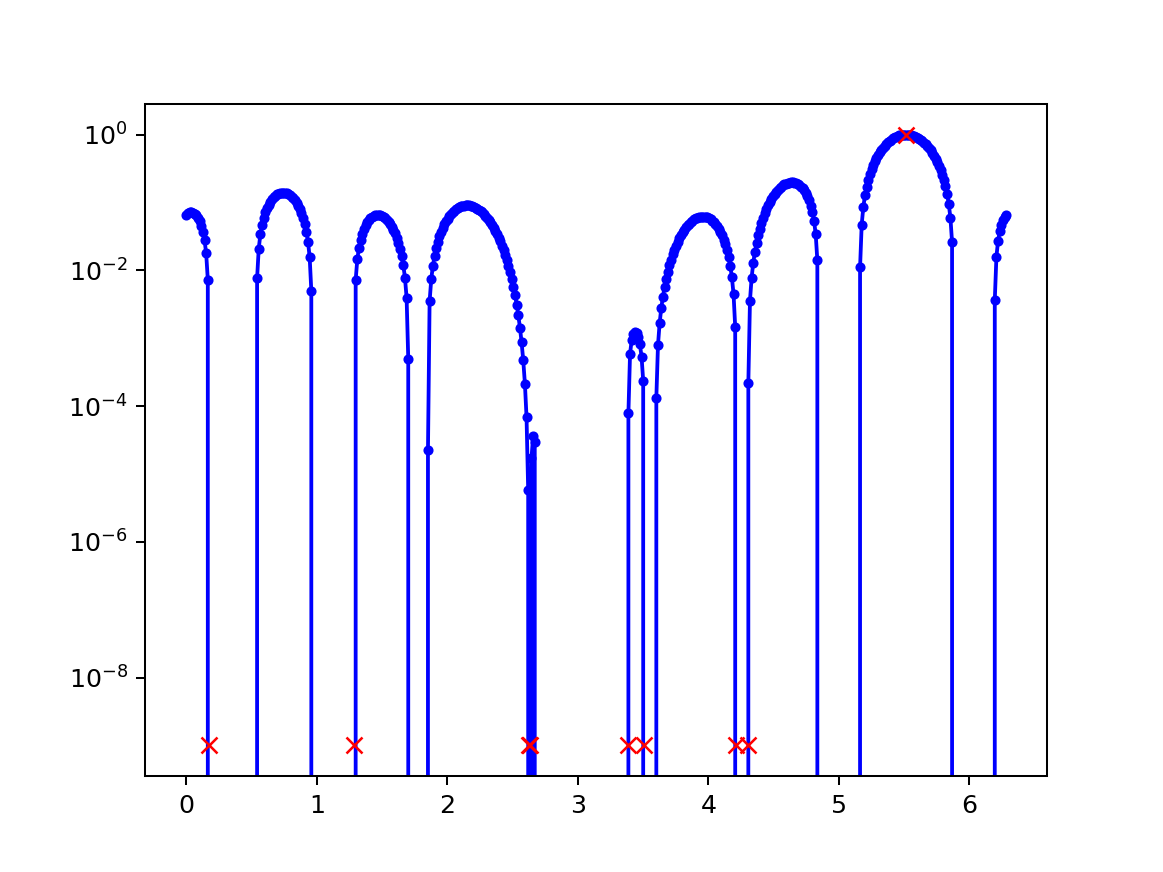

In [12]:
order = m
# n = 2*order + 1

x_test, y_hat, misfit = fit(X, Y, order)

plt.figure()
plt.semilogy(x_test, y_hat, 'b.-')
plt.semilogy(X, Y, 'rx')
plt.show()

Now there are still badly fitting spikes, but there peaks start to all go down...
The "noise energy" is getting spread across higher frequencies, and the average misfit to the truth goes down.


# n = 10m

Way more parameters than data points

Average misfit: 0.018198560249257582


<IPython.core.display.Javascript object>


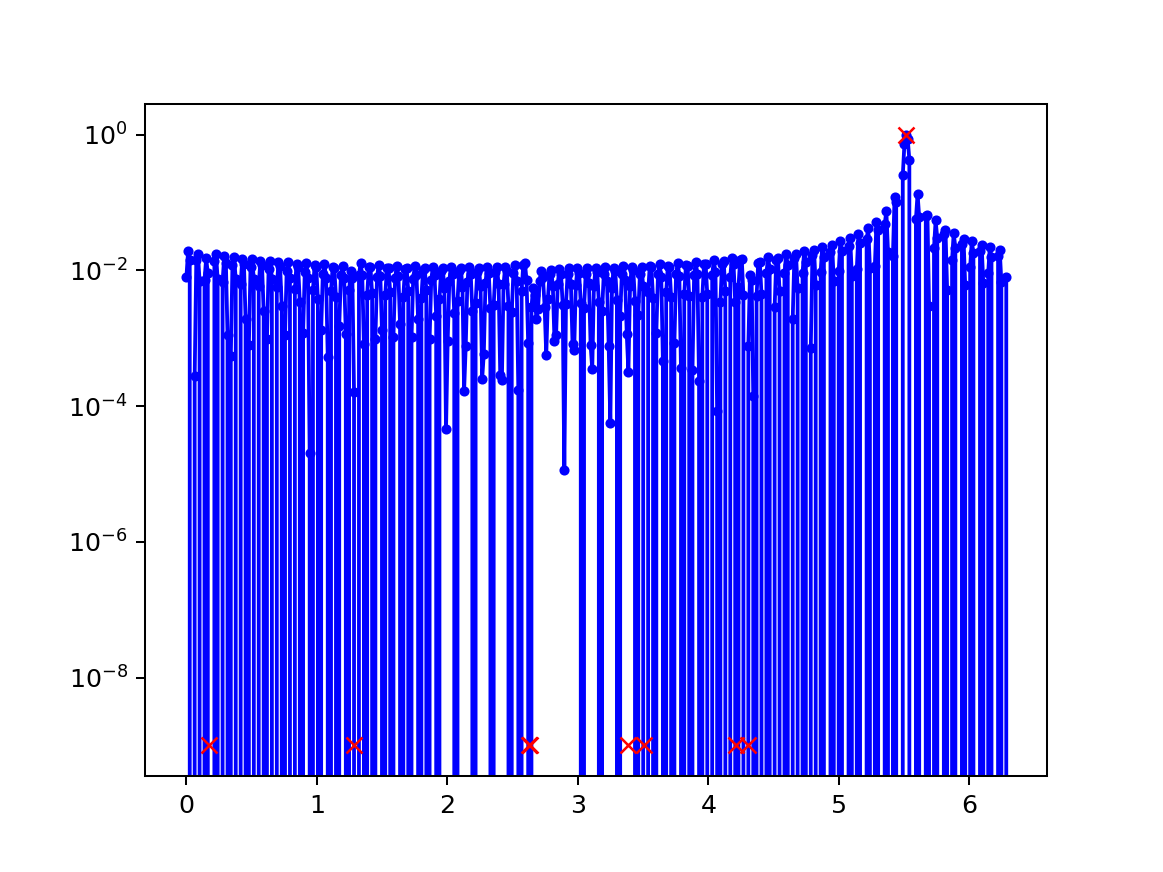

In [13]:
order = 10*m

x_test, y_hat, misfit = fit(X, Y, order)

plt.figure()
plt.semilogy(x_test, y_hat, 'b.-')
plt.semilogy(X, Y, 'rx')
plt.show()

# Show the misfit as a function of number of sin/cos terms

In [26]:
orders = list(range(0, 2*m)) + list(np.logspace(np.log10(2*m), np.log10(10*m), 10).astype(int))
ns = 2*np.array(orders) + 1
print(ns)

[  1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35
  35  43  51  61  73  89 105 125 151 181]


In [29]:
misfits = []
for order in orders:
    x_test, y_hat, misfit = fit(X, Y, order, print_misfit=False)
    misfits.append(misfit)


<IPython.core.display.Javascript object>


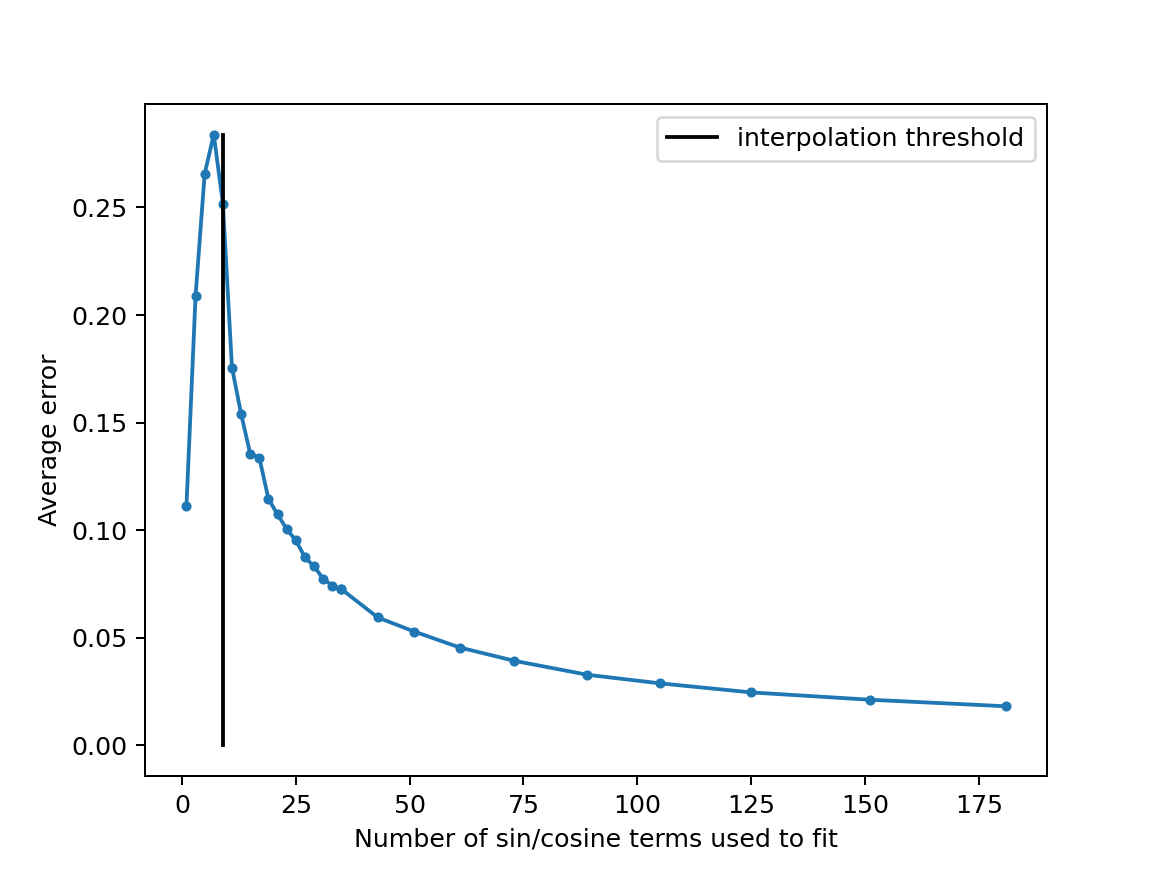

In [32]:
interp_thresh = m
plt.figure();
plt.plot(ns, misfits, '.-')
plt.plot(np.ones(5) * interp_thresh, np.linspace(0, np.max(misfits), 5), 'k-', label='interpolation threshold')
plt.ylabel("Average error")
plt.xlabel("Number of sin/cosine terms used to fit")
plt.legend()

### References

This was attempting one example of Figure 2 in https://arxiv.org/pdf/1903.09139.pdf